# DQN with rated memory replay

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import numpy as np

state = env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    #     print('state, action, reward, done, info:', 
    #           state, action, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][0].shape

([array([ 0.04938155,  0.01670427, -0.04674232, -0.0214621 ]),
  0,
  array([ 0.04971564, -0.17771727, -0.04717156,  0.25611443]),
  1.0,
  0.0],
 (4,))

In [5]:
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 float64
1 0
2
1.0 1.0
2.417938841589041 -2.804054554699768


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states, actions, targetQs, action_size, hidden_size):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [10]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
def sample(batch_size, ListArr):
    idx = np.random.choice(np.arange(len(ListArr)), 
                           size=batch_size, 
                           replace=True)
    return [ListArr[ii] for ii in idx]

In [14]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [16]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 24*2             # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size
gamma = 0.99                   # future reward discount

In [17]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [20]:
# Initializing the memory with the pool of random exploration of the env.
goal = 500 # env-based, the total reward required for reaching the goal G
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/goal # the actual sucess rate of the played sequence
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

In [32]:
rates = np.array(memory.buffer)[:, 5]
rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.5)]
batch = sample(ListArr=rated_mem, batch_size=batch_size)
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [38]:
rated_mem = np.array(memory.buffer)#[rates >= (max(rates)*0.5)]
batch = sample(ListArr=rated_mem, batch_size=batch_size)
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [42]:
# rated_mem = np.array(memory.buffer)#[rates >= (max(rates)*0.5)]
batch = sample(ListArr=memory.buffer, batch_size=batch_size)
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [43]:
states.shape, states.dtype, actions.shape, actions.dtype, next_states.shape, next_states.dtype, \
rewards.shape, rewards.dtype, dones.shape, dones.dtype, rates.shape, rates.dtype

((100, 4),
 dtype('float64'),
 (100,),
 dtype('int64'),
 (100, 4),
 dtype('float64'),
 (100,),
 dtype('float64'),
 (100,),
 dtype('float64'),
 (100,),
 dtype('float64'))

In [44]:
rates

array([0.024, 0.034, 0.034, 0.022, 0.036, 0.046, 0.054, 0.09 , 0.062,
       0.026, 0.092, 0.04 , 0.114, 0.082, 0.026, 0.058, 0.042, 0.084,
       0.04 , 0.06 , 0.036, 0.144, 0.06 , 0.09 , 0.034, 0.054, 0.058,
       0.022, 0.054, 0.146, 0.032, 0.078, 0.05 , 0.048, 0.11 , 0.032,
       0.062, 0.048, 0.02 , 0.078, 0.048, 0.04 , 0.032, 0.032, 0.09 ,
       0.118, 0.064, 0.032, 0.068, 0.05 , 0.038, 0.054, 0.108, 0.05 ,
       0.106, 0.032, 0.022, 0.072, 0.062, 0.046, 0.024, 0.052, 0.114,
       0.032, 0.042, 0.034, 0.098, 0.034, 0.092, 0.034, 0.032, 0.066,
       0.02 , 0.07 , 0.022, 0.046, 0.038, 0.028, 0.018, 0.032, 0.052,
       0.07 , 0.036, 0.058, 0.05 , 0.052, 0.038, 0.022, 0.028, 0.046,
       0.06 , 0.04 , 0.052, 0.086, 0.036, 0.08 , 0.042, 0.088, 0.022,
       0.04 ])

In [45]:
dones

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [46]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state

            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
                        
            # Rating and training the memory
            #rates = np.array(memory.buffer)[:, 5]
            rated_mem = np.array(memory.buffer)#[rates >= (max(rates)*0.5)]
            batch = sample(ListArr=rated_mem, batch_size=batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #rates = np.array([each[5] for each in batch])
            #nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0 rate:0.0420 loss:1.0820 exploreP:0.9979
Episode:1 meanR:15.5000 R:10.0 rate:0.0200 loss:1.1045 exploreP:0.9969
Episode:2 meanR:15.6667 R:16.0 rate:0.0320 loss:1.1192 exploreP:0.9954
Episode:3 meanR:17.7500 R:24.0 rate:0.0480 loss:1.1510 exploreP:0.9930
Episode:4 meanR:18.2000 R:20.0 rate:0.0400 loss:1.2002 exploreP:0.9910
Episode:5 meanR:18.3333 R:19.0 rate:0.0380 loss:1.2489 exploreP:0.9892
Episode:6 meanR:28.7143 R:91.0 rate:0.1820 loss:1.4281 exploreP:0.9803
Episode:7 meanR:26.7500 R:13.0 rate:0.0260 loss:1.6099 exploreP:0.9790
Episode:8 meanR:24.8889 R:10.0 rate:0.0200 loss:1.6279 exploreP:0.9781
Episode:9 meanR:24.5000 R:21.0 rate:0.0420 loss:1.7024 exploreP:0.9760
Episode:10 meanR:23.7273 R:16.0 rate:0.0320 loss:1.7112 exploreP:0.9745
Episode:11 meanR:23.4167 R:20.0 rate:0.0400 loss:1.6942 exploreP:0.9726
Episode:12 meanR:23.1538 R:20.0 rate:0.0400 loss:1.7354 exploreP:0.9706
Episode:13 meanR:22.3571 R:12.0 rate:0.0240 loss:1.7623 exploreP:0.9695
Ep

Episode:113 meanR:20.6600 R:51.0 rate:0.1020 loss:17.3472 exploreP:0.7904
Episode:114 meanR:20.6400 R:23.0 rate:0.0460 loss:17.1250 exploreP:0.7886
Episode:115 meanR:20.3700 R:23.0 rate:0.0460 loss:16.5269 exploreP:0.7868
Episode:116 meanR:20.7100 R:78.0 rate:0.1560 loss:16.3522 exploreP:0.7808
Episode:117 meanR:20.7600 R:23.0 rate:0.0460 loss:17.7201 exploreP:0.7790
Episode:118 meanR:21.1700 R:50.0 rate:0.1000 loss:17.4492 exploreP:0.7752
Episode:119 meanR:21.2700 R:22.0 rate:0.0440 loss:19.8470 exploreP:0.7735
Episode:120 meanR:21.3500 R:22.0 rate:0.0440 loss:14.5360 exploreP:0.7718
Episode:121 meanR:21.5700 R:38.0 rate:0.0760 loss:15.2905 exploreP:0.7689
Episode:122 meanR:21.9300 R:49.0 rate:0.0980 loss:17.7834 exploreP:0.7652
Episode:123 meanR:22.0700 R:30.0 rate:0.0600 loss:17.0921 exploreP:0.7630
Episode:124 meanR:22.8400 R:117.0 rate:0.2340 loss:18.7169 exploreP:0.7542
Episode:125 meanR:22.8400 R:11.0 rate:0.0220 loss:17.4384 exploreP:0.7534
Episode:126 meanR:23.1600 R:48.0 rate

Episode:224 meanR:45.2000 R:12.0 rate:0.0240 loss:69.8363 exploreP:0.4836
Episode:225 meanR:45.6000 R:51.0 rate:0.1020 loss:62.1573 exploreP:0.4812
Episode:226 meanR:45.7500 R:63.0 rate:0.1260 loss:64.5136 exploreP:0.4782
Episode:227 meanR:45.7300 R:57.0 rate:0.1140 loss:61.8010 exploreP:0.4755
Episode:228 meanR:46.0200 R:48.0 rate:0.0960 loss:72.6692 exploreP:0.4733
Episode:229 meanR:46.3200 R:60.0 rate:0.1200 loss:60.0507 exploreP:0.4705
Episode:230 meanR:46.7800 R:65.0 rate:0.1300 loss:66.4132 exploreP:0.4676
Episode:231 meanR:47.1900 R:62.0 rate:0.1240 loss:65.7507 exploreP:0.4647
Episode:232 meanR:47.2200 R:70.0 rate:0.1400 loss:58.9769 exploreP:0.4616
Episode:233 meanR:47.4800 R:93.0 rate:0.1860 loss:66.6409 exploreP:0.4574
Episode:234 meanR:47.3300 R:54.0 rate:0.1080 loss:71.4158 exploreP:0.4550
Episode:235 meanR:47.3600 R:25.0 rate:0.0500 loss:62.9877 exploreP:0.4539
Episode:236 meanR:47.5000 R:53.0 rate:0.1060 loss:72.4905 exploreP:0.4515
Episode:237 meanR:48.1200 R:76.0 rate:

Episode:333 meanR:151.3800 R:296.0 rate:0.5920 loss:672.3508 exploreP:0.1085
Episode:334 meanR:155.1100 R:427.0 rate:0.8540 loss:683.2068 exploreP:0.1043
Episode:335 meanR:157.7300 R:287.0 rate:0.5740 loss:732.0486 exploreP:0.1017
Episode:336 meanR:159.9500 R:275.0 rate:0.5500 loss:767.8864 exploreP:0.0992
Episode:337 meanR:161.2300 R:204.0 rate:0.4080 loss:756.2195 exploreP:0.0974
Episode:338 meanR:163.5600 R:314.0 rate:0.6280 loss:839.5916 exploreP:0.0947
Episode:339 meanR:165.8800 R:265.0 rate:0.5300 loss:867.9914 exploreP:0.0925
Episode:340 meanR:168.7800 R:325.0 rate:0.6500 loss:915.8359 exploreP:0.0898
Episode:341 meanR:170.5300 R:213.0 rate:0.4260 loss:948.6433 exploreP:0.0881
Episode:342 meanR:172.2700 R:245.0 rate:0.4900 loss:994.8324 exploreP:0.0863
Episode:343 meanR:173.7500 R:238.0 rate:0.4760 loss:992.7271 exploreP:0.0845
Episode:344 meanR:175.3800 R:276.0 rate:0.5520 loss:1054.1512 exploreP:0.0824
Episode:345 meanR:177.1600 R:212.0 rate:0.4240 loss:1095.0275 exploreP:0.08

Episode:438 meanR:263.7300 R:317.0 rate:0.6340 loss:25898.7910 exploreP:0.0161
Episode:439 meanR:263.1500 R:207.0 rate:0.4140 loss:27938.5801 exploreP:0.0159
Episode:440 meanR:262.9000 R:300.0 rate:0.6000 loss:28746.2363 exploreP:0.0158
Episode:441 meanR:262.6100 R:184.0 rate:0.3680 loss:31064.6934 exploreP:0.0157
Episode:442 meanR:263.5700 R:341.0 rate:0.6820 loss:33824.0703 exploreP:0.0155
Episode:443 meanR:262.6000 R:141.0 rate:0.2820 loss:33321.5312 exploreP:0.0154
Episode:444 meanR:262.4400 R:260.0 rate:0.5200 loss:36758.6250 exploreP:0.0153
Episode:445 meanR:262.4000 R:208.0 rate:0.4160 loss:38413.9141 exploreP:0.0151
Episode:446 meanR:261.4100 R:225.0 rate:0.4500 loss:38353.3867 exploreP:0.0150
Episode:447 meanR:259.4300 R:302.0 rate:0.6040 loss:42262.4219 exploreP:0.0149
Episode:448 meanR:260.4400 R:383.0 rate:0.7660 loss:46515.3906 exploreP:0.0147
Episode:449 meanR:260.9600 R:281.0 rate:0.5620 loss:49741.8086 exploreP:0.0146
Episode:450 meanR:260.5300 R:244.0 rate:0.4880 loss:

Episode:541 meanR:215.0300 R:119.0 rate:0.2380 loss:840845.4375 exploreP:0.0107
Episode:542 meanR:212.8000 R:118.0 rate:0.2360 loss:814726.4375 exploreP:0.0107
Episode:543 meanR:212.7400 R:135.0 rate:0.2700 loss:803730.2500 exploreP:0.0106
Episode:544 meanR:211.8000 R:166.0 rate:0.3320 loss:869262.2500 exploreP:0.0106
Episode:545 meanR:211.0600 R:134.0 rate:0.2680 loss:905756.5625 exploreP:0.0106
Episode:546 meanR:210.0200 R:121.0 rate:0.2420 loss:875718.8125 exploreP:0.0106
Episode:547 meanR:208.3400 R:134.0 rate:0.2680 loss:972353.8125 exploreP:0.0106
Episode:548 meanR:205.6900 R:118.0 rate:0.2360 loss:911229.3750 exploreP:0.0106
Episode:549 meanR:204.5000 R:162.0 rate:0.3240 loss:868769.5000 exploreP:0.0106
Episode:550 meanR:203.2400 R:118.0 rate:0.2360 loss:869188.8750 exploreP:0.0106
Episode:551 meanR:202.5300 R:220.0 rate:0.4400 loss:920614.0625 exploreP:0.0106
Episode:552 meanR:202.0900 R:132.0 rate:0.2640 loss:934487.8750 exploreP:0.0106
Episode:553 meanR:200.4400 R:110.0 rate:

Episode:643 meanR:221.9100 R:500.0 rate:1.0000 loss:1139957.1250 exploreP:0.0101
Episode:644 meanR:225.2500 R:500.0 rate:1.0000 loss:1125833.2500 exploreP:0.0101
Episode:645 meanR:228.9100 R:500.0 rate:1.0000 loss:1081086.3750 exploreP:0.0101
Episode:646 meanR:232.7000 R:500.0 rate:1.0000 loss:1061826.1250 exploreP:0.0101
Episode:647 meanR:236.3600 R:500.0 rate:1.0000 loss:1061783.5000 exploreP:0.0101
Episode:648 meanR:240.1800 R:500.0 rate:1.0000 loss:1030596.8750 exploreP:0.0101
Episode:649 meanR:243.5600 R:500.0 rate:1.0000 loss:1035146.5000 exploreP:0.0101
Episode:650 meanR:247.3800 R:500.0 rate:1.0000 loss:971354.3125 exploreP:0.0100
Episode:651 meanR:250.1800 R:500.0 rate:1.0000 loss:967325.3125 exploreP:0.0100
Episode:652 meanR:253.8600 R:500.0 rate:1.0000 loss:912479.0625 exploreP:0.0100
Episode:653 meanR:257.7600 R:500.0 rate:1.0000 loss:888181.3750 exploreP:0.0100
Episode:654 meanR:261.3500 R:500.0 rate:1.0000 loss:871125.1875 exploreP:0.0100
Episode:655 meanR:265.3100 R:500.

Episode:747 meanR:72.0100 R:11.0 rate:0.0220 loss:348469.5938 exploreP:0.0100
Episode:748 meanR:67.1200 R:11.0 rate:0.0220 loss:364104.0312 exploreP:0.0100
Episode:749 meanR:62.2200 R:10.0 rate:0.0200 loss:415123.8438 exploreP:0.0100
Episode:750 meanR:57.3300 R:11.0 rate:0.0220 loss:414434.0312 exploreP:0.0100
Episode:751 meanR:57.3300 R:500.0 rate:1.0000 loss:493746.4375 exploreP:0.0100
Episode:752 meanR:54.1700 R:184.0 rate:0.3680 loss:655854.6250 exploreP:0.0100
Episode:753 meanR:50.6000 R:143.0 rate:0.2860 loss:757093.1250 exploreP:0.0100
Episode:754 meanR:46.9400 R:134.0 rate:0.2680 loss:770269.0625 exploreP:0.0100
Episode:755 meanR:43.2600 R:132.0 rate:0.2640 loss:811011.6250 exploreP:0.0100
Episode:756 meanR:39.5300 R:127.0 rate:0.2540 loss:765909.0000 exploreP:0.0100
Episode:757 meanR:35.7700 R:124.0 rate:0.2480 loss:802071.1250 exploreP:0.0100
Episode:758 meanR:32.0200 R:125.0 rate:0.2500 loss:814710.3125 exploreP:0.0100
Episode:759 meanR:28.1900 R:117.0 rate:0.2340 loss:81149

Episode:852 meanR:27.1000 R:11.0 rate:0.0220 loss:290175.9062 exploreP:0.0100
Episode:853 meanR:25.7900 R:12.0 rate:0.0240 loss:305914.2188 exploreP:0.0100
Episode:854 meanR:24.5800 R:13.0 rate:0.0260 loss:367033.1250 exploreP:0.0100
Episode:855 meanR:23.3600 R:10.0 rate:0.0200 loss:415965.5625 exploreP:0.0100
Episode:856 meanR:22.2100 R:12.0 rate:0.0240 loss:362735.5938 exploreP:0.0100
Episode:857 meanR:21.1000 R:13.0 rate:0.0260 loss:394784.5312 exploreP:0.0100
Episode:858 meanR:19.9800 R:13.0 rate:0.0260 loss:303231.9062 exploreP:0.0100
Episode:859 meanR:18.9400 R:13.0 rate:0.0260 loss:239012.0000 exploreP:0.0100
Episode:860 meanR:17.9000 R:14.0 rate:0.0280 loss:365668.3125 exploreP:0.0100
Episode:861 meanR:16.9700 R:11.0 rate:0.0220 loss:370206.0000 exploreP:0.0100
Episode:862 meanR:16.0800 R:14.0 rate:0.0280 loss:344298.9062 exploreP:0.0100
Episode:863 meanR:15.0900 R:12.0 rate:0.0240 loss:327862.3750 exploreP:0.0100
Episode:864 meanR:14.1400 R:11.0 rate:0.0220 loss:274159.0312 ex

Episode:955 meanR:313.0200 R:500.0 rate:1.0000 loss:771858.1875 exploreP:0.0100
Episode:956 meanR:317.9000 R:500.0 rate:1.0000 loss:751061.4375 exploreP:0.0100
Episode:957 meanR:322.7700 R:500.0 rate:1.0000 loss:736716.9375 exploreP:0.0100
Episode:958 meanR:327.6400 R:500.0 rate:1.0000 loss:726719.6250 exploreP:0.0100
Episode:959 meanR:332.5100 R:500.0 rate:1.0000 loss:716269.4375 exploreP:0.0100
Episode:960 meanR:337.3700 R:500.0 rate:1.0000 loss:710537.5000 exploreP:0.0100
Episode:961 meanR:342.2600 R:500.0 rate:1.0000 loss:719419.5000 exploreP:0.0100
Episode:962 meanR:347.1200 R:500.0 rate:1.0000 loss:683523.7500 exploreP:0.0100
Episode:963 meanR:352.0000 R:500.0 rate:1.0000 loss:674345.8750 exploreP:0.0100
Episode:964 meanR:356.8900 R:500.0 rate:1.0000 loss:670954.8125 exploreP:0.0100
Episode:965 meanR:361.7600 R:500.0 rate:1.0000 loss:656449.5625 exploreP:0.0100
Episode:966 meanR:366.6100 R:500.0 rate:1.0000 loss:647926.5000 exploreP:0.0100
Episode:967 meanR:371.4900 R:500.0 rate:

Episode:1057 meanR:498.0000 R:500.0 rate:1.0000 loss:156257.8750 exploreP:0.0100
Episode:1058 meanR:498.0000 R:500.0 rate:1.0000 loss:165090.9688 exploreP:0.0100
Episode:1059 meanR:498.0000 R:500.0 rate:1.0000 loss:146688.2188 exploreP:0.0100
Episode:1060 meanR:498.0000 R:500.0 rate:1.0000 loss:158078.7188 exploreP:0.0100
Episode:1061 meanR:498.0000 R:500.0 rate:1.0000 loss:163521.0938 exploreP:0.0100
Episode:1062 meanR:498.0000 R:500.0 rate:1.0000 loss:145987.6875 exploreP:0.0100
Episode:1063 meanR:498.0000 R:500.0 rate:1.0000 loss:152570.4375 exploreP:0.0100
Episode:1064 meanR:498.0000 R:500.0 rate:1.0000 loss:152699.3281 exploreP:0.0100
Episode:1065 meanR:498.0000 R:500.0 rate:1.0000 loss:161457.2500 exploreP:0.0100
Episode:1066 meanR:498.0000 R:500.0 rate:1.0000 loss:156585.3125 exploreP:0.0100
Episode:1067 meanR:498.0000 R:500.0 rate:1.0000 loss:143199.6250 exploreP:0.0100
Episode:1068 meanR:498.0000 R:500.0 rate:1.0000 loss:142953.9375 exploreP:0.0100
Episode:1069 meanR:498.0000 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

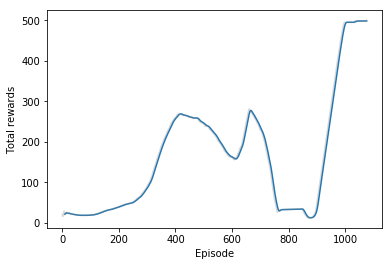

In [48]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

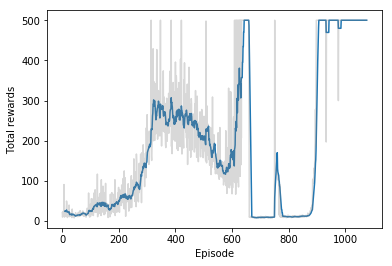

In [49]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

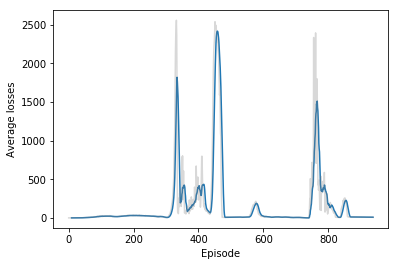

In [25]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.